In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [21]:
from tensorflow.examples.tutorials.mnist import input_data


In [22]:
mnist=input_data.read_data_sets("MNIST_data/")
trX, trY, teX, teY= mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [23]:
class DenoisingAutoEncoder(object):
    def __init__(self, m, n, eta=0.01):
        #m : number of neuons in input/output layer
        # n : number of neurons in hidden layer
        
        self._m= m
        self._n= n
        self.learning_rate=eta
        
        #Create a Computational graph
        
        #weights and biases
        self._w1=tf.Variable(tf.random_normal(shape=(self._m, self._n)))
        self._w2=tf.Variable(tf.random.normal(shape=(self._n, self._m)))
        
        self._b1=tf.Variable(np.zeros(self._n).astype(np.float32))
        self._b2=tf.Variable(np.zeros(self._m).astype(np.float32))
        
        #Placeholder for inputs
        
        self._X=tf.placeholder(tf.float32, shape=[None, self._m])
        
        self._X_noisy= tf.placeholder(tf.float32, shape=[None, self._m])

        self.y=self.encoder(self._X)
        self.r=self.decoder(self.y)
        
        error=self.r= self._X
        
        self._loss= tf.reduce_mean(tf.pow(error, 2))
        
        alpha=0.05
        kl_div_loss=tf.reduce_mean(self.kl_div(0.02, tf.reduce_mean(self.y, 0)))
        loss=self._loss + alpha*kl_div_loss
        
        self._opt= tf.train.AdamOptimizer(self.learning_rate).minimize(loss)
        
        
    def encoder(self, x):
        h=tf.matmul(x, self._w1) + self._b1
        return tf.nn.sigmoid(h)
    
    def decoder(self, x):
        h=tf.matmul(x, self._w2) + self._b2
        return tf.nn.sigmoid(h)
    
    def set_session(self, session):
        self.session = session
        
    def reconstruct(self, x):
        h= self.encoder(x)
        r=self.decoder(h)
        return self.session.run(r, feed_dict= {self._X : x})
    
    def kl_div(self, rho, rho_hat):
        term2_num = tf.constant(1.) - rho
        term2_den = tf.constant(1.) - rho_hat
        
        kl= self.logfunc(rho, rho_hat) + self.logfunc(term2_num, term2_den)
        return kl
    
    def logfunc(self, x1, x2):
        return tf.multiply(x1, tf.log(tf.div(x1, x2)))
    
    def corrupt(self, x):
        return x*tf.cast(tf.random_uniform(shape=tf.shape(x), minval=0, maxval=2), tf.float32)
    
    def getWeights(self):
        return self.session.run([self._w1, self._w2, self._b1, self._b2])
    
    def fit(self, X, Xorg, epochs=50, batch_size= 100):
        N, D= X.shape
        num_batches= N//batch_size
        
        obj=[]
        
        for i in range(epochs):
            for j in range(num_batches):
                batch= X[j*batch_size : (j* batch_size + batch_size)]
                batchO= Xorg[j* batch_size : (j *batch_size + batch_size)]
                
                _, ob= self.session.run([self._opt, self._loss], feed_dict= {self._X:batchO, self._X_noisy: batch})
                
                if j%100 ==0:
                    print('training epoch {0} batch {2} cost {1}'.format(i, ob, j))
                    obj.append(ob)
        return obj
                    

In [24]:
def corruption( x, noise_factor = 0.3):   # corruption of the input
    noisy_imgs= x+ noise_factor*np.random.randn(*x.shape)
    noisy_imgs=np.clip(noisy_imgs, 0. , 1.)
    return noisy_imgs

In [25]:
n_hidden= 1000
Xtrain= trX.astype(np.float32)
Xtrain_noisy= corruption (Xtrain).astype(np.float32)
Xtest= teX.astype(np.float32)
# noise= Xtest * np.random.randint(0, 2, Xtest.shape).astype(np.float32)
Xtest_noisy= corruption(Xtest).astype(np.float32)

_, m= Xtrain.shape

dae= DenoisingAutoEncoder( m, n_hidden)

#Initialise all variables
init= tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    dae.set_session(sess)
    err= dae.fit(Xtrain_noisy, Xtrain, epochs=50)
    out= dae.reconstruct(Xtest_noisy[0:100])
    #w1, w2, b1, b2 = dae.getWeights()
    #red= dae.reduced_dimension(Xtrain)
                

training epoch 0 batch 0 cost 0.11744999885559082
training epoch 0 batch 100 cost 0.10667049139738083
training epoch 0 batch 200 cost 0.10857931524515152
training epoch 0 batch 300 cost 0.11918950080871582
training epoch 0 batch 400 cost 0.1134793758392334
training epoch 0 batch 500 cost 0.11265762150287628
training epoch 1 batch 0 cost 0.11744999885559082
training epoch 1 batch 100 cost 0.10667049139738083
training epoch 1 batch 200 cost 0.10857931524515152
training epoch 1 batch 300 cost 0.11918950080871582
training epoch 1 batch 400 cost 0.1134793758392334
training epoch 1 batch 500 cost 0.11265762150287628
training epoch 2 batch 0 cost 0.11744999885559082
training epoch 2 batch 100 cost 0.10667049139738083
training epoch 2 batch 200 cost 0.10857931524515152
training epoch 2 batch 300 cost 0.11918950080871582
training epoch 2 batch 400 cost 0.1134793758392334
training epoch 2 batch 500 cost 0.11265762150287628
training epoch 3 batch 0 cost 0.11744999885559082
training epoch 3 batch 

training epoch 26 batch 200 cost 0.10857931524515152
training epoch 26 batch 300 cost 0.11918950080871582
training epoch 26 batch 400 cost 0.1134793758392334
training epoch 26 batch 500 cost 0.11265762150287628
training epoch 27 batch 0 cost 0.11744999885559082
training epoch 27 batch 100 cost 0.10667049139738083
training epoch 27 batch 200 cost 0.10857931524515152
training epoch 27 batch 300 cost 0.11918950080871582
training epoch 27 batch 400 cost 0.1134793758392334
training epoch 27 batch 500 cost 0.11265762150287628
training epoch 28 batch 0 cost 0.11744999885559082
training epoch 28 batch 100 cost 0.10667049139738083
training epoch 28 batch 200 cost 0.10857931524515152
training epoch 28 batch 300 cost 0.11918950080871582
training epoch 28 batch 400 cost 0.1134793758392334
training epoch 28 batch 500 cost 0.11265762150287628
training epoch 29 batch 0 cost 0.11744999885559082
training epoch 29 batch 100 cost 0.10667049139738083
training epoch 29 batch 200 cost 0.10857931524515152
tr

Text(0, 0.5, 'reconstruction Loss (MSE)')

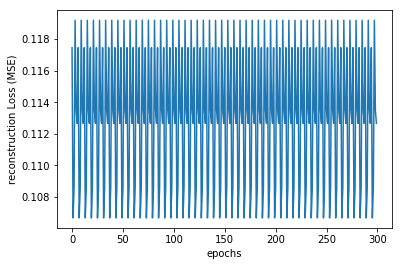

In [26]:
import matplotlib.pyplot as plt
plt.plot(err)
plt.xlabel('epochs')
plt.ylabel('reconstruction Loss (MSE)')


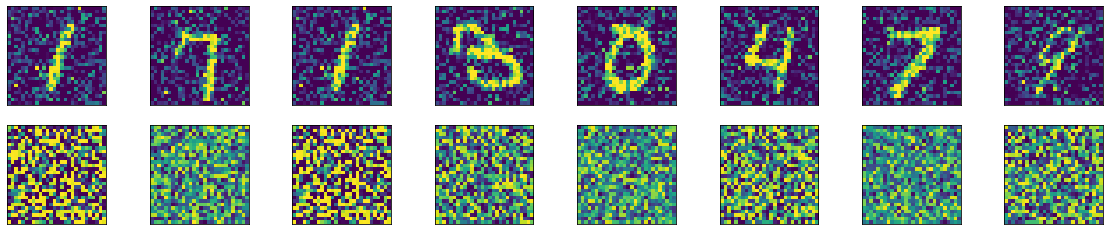

In [27]:
#plotting original and reconstructed image
row, col= 2,8
idx= np.random.randint(0, 100, row*col//2)
f, axarr= plt.subplots(row, col, sharex= True, sharey= True, figsize= (20, 4))
for fig, row in zip([Xtest_noisy, out], axarr):
    for i, ax in zip(idx, row):
        ax.imshow(fig[i].reshape((28, 28)))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)